In [1]:
import pickle
import os
import pandas as pd
from matplotlib import pyplot as plt
os.chdir(os.path.expanduser('~/wcEcoli/'))
# noinspection PyUnresolvedReferences
import numpy as np
import plotly.graph_objects as go
from models.ecoli.analysis import cohortAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader
from sklearn.metrics import r2_score
import plotly.graph_objects as go
import glob
import plotly.express as px

read in the priority substrate data

In [ ]:
# TODO: 
# 1. make this into a script that can be run and take in a simulation that it parses through the data for 
# 2. make a comparison script that looks between the counts of two sims for the change in protein counts plot (however, comparisons dont handle cohort plotting well, so maybe reading in the saved data from both is still optimal) 

In [3]:
# read in the priority protease data: 
priority_substrates = "models/ecoli/analysis/local_notebooks/protease_substrate_relationships/data/priority_protease_assignments_0.tsv"
priority_substrates = pd.read_csv(priority_substrates, sep='\t', skiprows=1)


common_names = "reconstruction/ecoli/scripts/protein_half_lives/Gupta_et_al_Clim_data/Clim_EcoCyc_monomer_ID_matches/41467_2024_49920_MOESM4_ESM_ST1_EcoCyc_monomer_ID_matches_11202024.tsv"
common_names = pd.read_csv(common_names, sep='\t', skiprows=1)

priority_substrates['common_name'] = None
for index, row in priority_substrates.iterrows():
    if row['id'] in common_names['Monomer ID'].values:
        priority_substrates.at[index, 'common_name'] = common_names[common_names['Monomer ID'] == row['id']]['Common Name'].values[0]
priority_substrates

,id,protease_assignment,ClpP,Lon,HslV,Unexplained,common_name
0,EG10156-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,clpA
1,MDLB-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,mdlB
2,EG10927-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,sbcC
3,EG10618-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,mukB
4,AERGLYC3PDEHYDROG-MONOMER,ClpP only,0.993731,0.000000,0.000000,0.000000,glpD
...,...,...,...,...,...,...,...
77,EG12690-MONOMER,"Additive: ClpP, Lon, HslV",0.277972,0.277364,0.378556,0.066108,rarA
78,PD03831,"Additive: ClpP, Lon",0.519958,0.403122,0.000000,0.076920,dnaA
79,AROK-MONOMER,"Additive: ClpP, Lon, HslV",0.319436,0.429511,0.167152,0.083901,aroK
80,G7263-MONOMER,"Additive: ClpP, Lon, HslV",0.183526,0.206054,0.520932,0.089488,murQ


In [4]:
# remove the common name column from the priority substrates data frame:
priority_substrates = priority_substrates.drop(columns=['common_name'])
priority_substrates

,id,protease_assignment,ClpP,Lon,HslV,Unexplained
0,EG10156-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000
1,MDLB-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000
2,EG10927-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000
3,EG10618-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000
4,AERGLYC3PDEHYDROG-MONOMER,ClpP only,0.993731,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
77,EG12690-MONOMER,"Additive: ClpP, Lon, HslV",0.277972,0.277364,0.378556,0.066108
78,PD03831,"Additive: ClpP, Lon",0.519958,0.403122,0.000000,0.076920
79,AROK-MONOMER,"Additive: ClpP, Lon, HslV",0.319436,0.429511,0.167152,0.083901
80,G7263-MONOMER,"Additive: ClpP, Lon, HslV",0.183526,0.206054,0.520932,0.089488


read in the half life data from CLNE1 (original model)

In [5]:
# read in the CLNE1 half life data: 
CLNE1_HLs = "out/CLNE1/kb_plot_out/protein_half_lives.tsv"
CLNE1_HLs = pd.read_csv(CLNE1_HLs, sep='\t')
CLNE1_HLs

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000019,600.0,N_end_rule
1,1-PFK-MONOMER,0.000019,600.0,N_end_rule
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.0,N_end_rule
3,2-ISOPROPYLMALATESYN-MONOMER,0.000019,600.0,N_end_rule
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000019,600.0,N_end_rule
...,...,...,...,...
4305,YTFR-MONOMER,0.000019,600.0,N_end_rule
4306,YTFT-MONOMER,0.000019,600.0,N_end_rule
4307,ZNUA-MONOMER,0.000019,600.0,N_end_rule
4308,ZNUB-MONOMER,0.000019,600.0,N_end_rule


In [6]:
# make a new data frame that contains the monomers that only have a half life of 600 in the half_life_(min) column of CLNE1_HLs:
CLNE1_HLs_600 = CLNE1_HLs[CLNE1_HLs['half_life_(min)'] == 600]
CLNE1_HLs_600

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000019,600.0,N_end_rule
1,1-PFK-MONOMER,0.000019,600.0,N_end_rule
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.0,N_end_rule
3,2-ISOPROPYLMALATESYN-MONOMER,0.000019,600.0,N_end_rule
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000019,600.0,N_end_rule
...,...,...,...,...
4305,YTFR-MONOMER,0.000019,600.0,N_end_rule
4306,YTFT-MONOMER,0.000019,600.0,N_end_rule
4307,ZNUA-MONOMER,0.000019,600.0,N_end_rule
4308,ZNUB-MONOMER,0.000019,600.0,N_end_rule


In [7]:
# make a new data frame that contains the monomers that only have a half life of 2 in the half_life_(min) column of CLNE1_HLs:
CLNE1_HLs_2 = CLNE1_HLs[CLNE1_HLs['half_life_(min)'] == 2]
CLNE1_HLs_2
# note, the remianing half lives are Covert lab assigned half lives!

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source
517,EG10506-MONOMER,0.005776,2.0,N_end_rule
611,EG10765-MONOMER,0.005776,2.0,N_end_rule
2754,G7426-MONOMER,0.005776,2.0,N_end_rule
3293,ISOCIT-LYASE-MONOMER,0.005776,2.0,N_end_rule
3787,OROPRIBTRANS-MONOMER,0.005776,2.0,N_end_rule
3887,PGPPHOSPHAB-MONOMER,0.005776,2.0,N_end_rule
3927,PPENTOMUT-MONOMER,0.005776,2.0,N_end_rule


read in the half life data from CLClim3NE1 (new proposed sort)

In [10]:
# read in the CLClim3NE1 half life data:
CLClim3NE1_HLs = "out/CLClim3NE1/kb_plot_out/protein_half_lives.tsv"
CLClim3NE1_HLs = pd.read_csv(CLClim3NE1_HLs, sep='\t')
CLClim3NE1_HLs


,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000023,501.707893,Gupta_et_al_MS_2024
1,1-PFK-MONOMER,0.000015,766.256894,Gupta_et_al_MS_2024
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.000000,N_end_rule
3,2-ISOPROPYLMALATESYN-MONOMER,0.000042,276.924332,Gupta_et_al_MS_2024
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000023,493.397050,Gupta_et_al_MS_2024
...,...,...,...,...
4305,YTFR-MONOMER,0.000018,654.149344,Gupta_et_al_MS_2024
4306,YTFT-MONOMER,0.000019,600.000000,N_end_rule
4307,ZNUA-MONOMER,0.000018,638.129701,Gupta_et_al_MS_2024
4308,ZNUB-MONOMER,0.000019,600.000000,N_end_rule


add the common name to the data frame too:

In [11]:
common_names = "reconstruction/ecoli/scripts/protein_half_lives/Gupta_et_al_Clim_data/Clim_EcoCyc_monomer_ID_matches/41467_2024_49920_MOESM4_ESM_ST1_EcoCyc_monomer_ID_matches_11202024.tsv"
common_names = pd.read_csv(common_names, sep='\t', skiprows=1)

CLClim3NE1_HLs['common_name'] = None
for index, row in CLClim3NE1_HLs.iterrows():
    if row['monomer_id'] in common_names['Monomer ID'].values:
        CLClim3NE1_HLs.at[index, 'common_name'] = common_names[common_names['Monomer ID'] == row['monomer_id']]['Common Name'].values[0]
   
CLClim3NE1_HLs

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source,common_name
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000023,501.707893,Gupta_et_al_MS_2024,plsC
1,1-PFK-MONOMER,0.000015,766.256894,Gupta_et_al_MS_2024,fruK
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.000000,N_end_rule,panE
3,2-ISOPROPYLMALATESYN-MONOMER,0.000042,276.924332,Gupta_et_al_MS_2024,leuA
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000023,493.397050,Gupta_et_al_MS_2024,ubiE
...,...,...,...,...,...
4305,YTFR-MONOMER,0.000018,654.149344,Gupta_et_al_MS_2024,ytfR
4306,YTFT-MONOMER,0.000019,600.000000,N_end_rule,ytfT
4307,ZNUA-MONOMER,0.000018,638.129701,Gupta_et_al_MS_2024,znuA
4308,ZNUB-MONOMER,0.000019,600.000000,N_end_rule,None


In [13]:
# make a new column in the CLClim3NE1_HLs_Clim3 data frame that contains the monomer_id's that are priority substrates:
# todo: delete in this file

CLClim3NE1_HLs['protease_assignment'] = "None"
for index, row in CLClim3NE1_HLs.iterrows():
    if row['monomer_id'] in priority_substrates['id'].values:
        CLClim3NE1_HLs.at[index, 'protease_assignment'] = priority_substrates[priority_substrates['id'] == row['monomer_id']]['protease_assignment'].values[0]
        #CLClim3NE1_HLs_Clim3.at[index, 'common_names'] = priority_substrates[priority_substrates['id'] == row['monomer_id']]['common_name'].values[0]
   
CLClim3NE1_HLs

,monomer_id,degradation_rate(1/s),half_life_(min),degradation_rate_source,common_name,protease_assignment
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000023,501.707893,Gupta_et_al_MS_2024,plsC,None
1,1-PFK-MONOMER,0.000015,766.256894,Gupta_et_al_MS_2024,fruK,None
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.000000,N_end_rule,panE,None
3,2-ISOPROPYLMALATESYN-MONOMER,0.000042,276.924332,Gupta_et_al_MS_2024,leuA,None
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000023,493.397050,Gupta_et_al_MS_2024,ubiE,None
...,...,...,...,...,...,...
4305,YTFR-MONOMER,0.000018,654.149344,Gupta_et_al_MS_2024,ytfR,None
4306,YTFT-MONOMER,0.000019,600.000000,N_end_rule,ytfT,None
4307,ZNUA-MONOMER,0.000018,638.129701,Gupta_et_al_MS_2024,znuA,None
4308,ZNUB-MONOMER,0.000019,600.000000,N_end_rule,None,None


Find the proteins in the CLClim3NE1_HLs data frame that have a half life of 600 in the half_life_(min) column

In [14]:
# make a new data frame from CLCLim3NE1_HLs that contains only the monomers that show up in CLNE1_HLs_600:
CLClim3NE1_HLs_were_600 = CLNE1_HLs_600.merge(CLClim3NE1_HLs, on='monomer_id', how='inner')
# remove columns 2, 3, and 4 from the data frame:
CLClim3NE1_HLs_were_600 = CLClim3NE1_HLs_were_600.drop(columns=['half_life_(min)_x', 'degradation_rate(1/s)_x', 'degradation_rate_source_x'])


CLClim3NE1_HLs_were_600 # 4296
# note that the other 600 min rate in here is the CL_measured_deg_rates_2020 rate for CdsA I think. So dont count that in here since it is not being reassigned. 


,monomer_id,degradation_rate(1/s)_y,half_life_(min)_y,degradation_rate_source_y,common_name,protease_assignment
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000023,501.707893,Gupta_et_al_MS_2024,plsC,None
1,1-PFK-MONOMER,0.000015,766.256894,Gupta_et_al_MS_2024,fruK,None
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.000000,N_end_rule,panE,None
3,2-ISOPROPYLMALATESYN-MONOMER,0.000042,276.924332,Gupta_et_al_MS_2024,leuA,None
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000023,493.397050,Gupta_et_al_MS_2024,ubiE,None
...,...,...,...,...,...,...
4291,YTFR-MONOMER,0.000018,654.149344,Gupta_et_al_MS_2024,ytfR,None
4292,YTFT-MONOMER,0.000019,600.000000,N_end_rule,ytfT,None
4293,ZNUA-MONOMER,0.000018,638.129701,Gupta_et_al_MS_2024,znuA,None
4294,ZNUB-MONOMER,0.000019,600.000000,N_end_rule,None,None


find the proteins that were 2 mins in the original model:

In [15]:
# make a new data frame from CLCLim3NE1_HLs that contains only the monomers that show up in CLNE1_HLs_2:
CLClim3NE1_HLs_were_2 = CLNE1_HLs_2.merge(CLClim3NE1_HLs, on='monomer_id', how='inner')
# remove columns 2, 3, and 4 from the data frame:
CLClim3NE1_HLs_were_2 = CLClim3NE1_HLs_were_2.drop(columns=['half_life_(min)_x', 'degradation_rate(1/s)_x', 'degradation_rate_source_x'])


CLClim3NE1_HLs_were_2 # 7



,monomer_id,degradation_rate(1/s)_y,half_life_(min)_y,degradation_rate_source_y,common_name,protease_assignment
0,EG10506-MONOMER,0.000018,659.511001,Gupta_et_al_MS_2024,infC,None
1,EG10765-MONOMER,0.000050,229.584501,Gupta_et_al_MS_2024,priC,None
2,G7426-MONOMER,0.000120,96.304300,Gupta_et_al_MS_2024,casE,None
3,ISOCIT-LYASE-MONOMER,0.000023,506.342742,Gupta_et_al_MS_2024,aceA,None
4,OROPRIBTRANS-MONOMER,0.000021,558.233686,Gupta_et_al_MS_2024,pyrE,None
5,PGPPHOSPHAB-MONOMER,0.000012,935.775109,Gupta_et_al_MS_2024,pgpB,None
6,PPENTOMUT-MONOMER,0.000021,553.128667,Gupta_et_al_MS_2024,deoB,None


find the proteins that still are 600 mins in the new model

In [16]:
CLClim3NE1_HLs_still_600 = CLClim3NE1_HLs_were_600[CLClim3NE1_HLs_were_600['degradation_rate_source_y'] == "N_end_rule"]
CLClim3NE1_HLs_still_600 # 1628

,monomer_id,degradation_rate(1/s)_y,half_life_(min)_y,degradation_rate_source_y,common_name,protease_assignment
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,0.000019,600.0,N_end_rule,panE,None
19,ABGT-MONOMER,0.000019,600.0,N_end_rule,None,None
30,ACPSUB-MONOMER,0.000019,600.0,N_end_rule,citD,None
33,ACRF-MONOMER,0.000019,600.0,N_end_rule,acrF,None
51,AGAC-MONOMER,0.000019,600.0,N_end_rule,None,None
...,...,...,...,...,...,...
4285,YPHE-MONOMER,0.000019,600.0,N_end_rule,yphE,None
4287,YRBE-MONOMER,0.000019,600.0,N_end_rule,mlaE,None
4289,YRBG-MONOMER,0.000019,600.0,N_end_rule,yrbG,None
4292,YTFT-MONOMER,0.000019,600.0,N_end_rule,ytfT,None


find the proteins that are no longer 600 mins in the new model

In [36]:
CLClim3NE1_HLs_Clim3 = CLClim3NE1_HLs_were_600[CLClim3NE1_HLs_were_600['degradation_rate_source_y'] == "Gupta_et_al_MS_2024"]
CLClim3NE1_HLs_Clim3_600 = CLClim3NE1_HLs_Clim3.copy()
CLClim3NE1_HLs_Clim3_600['original_half_life'] = 600
CLClim3NE1_HLs_Clim3_600 # 2667

,monomer_id,degradation_rate(1/s)_y,half_life_(min)_y,degradation_rate_source_y,common_name,protease_assignment,original_half_life
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000023,501.707893,Gupta_et_al_MS_2024,plsC,None,600
1,1-PFK-MONOMER,0.000015,766.256894,Gupta_et_al_MS_2024,fruK,None,600
3,2-ISOPROPYLMALATESYN-MONOMER,0.000042,276.924332,Gupta_et_al_MS_2024,leuA,None,600
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000023,493.397050,Gupta_et_al_MS_2024,ubiE,None,600
5,2-OCTAPRENYLPHENOL-HYDROX-MONOMER,0.000015,796.038829,Gupta_et_al_MS_2024,ubiB,None,600
...,...,...,...,...,...,...,...
4288,YRBF-MONOMER,0.000014,823.833163,Gupta_et_al_MS_2024,mlaF,None,600
4290,YTFQ-MONOMER,0.000015,790.418789,Gupta_et_al_MS_2024,ytfQ,None,600
4291,YTFR-MONOMER,0.000018,654.149344,Gupta_et_al_MS_2024,ytfR,None,600
4293,ZNUA-MONOMER,0.000018,638.129701,Gupta_et_al_MS_2024,znuA,None,600


Find the proteins that were 2 minutes in the model and are now assigned to gupta rates

In [37]:
CLClim3NE1_HLs_Clim3_2 = CLClim3NE1_HLs_were_2[CLClim3NE1_HLs_were_2['degradation_rate_source_y'] == "Gupta_et_al_MS_2024"] # all 7 change
CLClim3NE1_HLs_Clim3_2 = CLClim3NE1_HLs_Clim3_2.copy()
CLClim3NE1_HLs_Clim3_2['original_half_life'] = 2

CLClim3NE1_HLs_Clim3_2 # 7

,monomer_id,degradation_rate(1/s)_y,half_life_(min)_y,degradation_rate_source_y,common_name,protease_assignment,original_half_life
0,EG10506-MONOMER,0.000018,659.511001,Gupta_et_al_MS_2024,infC,None,2
1,EG10765-MONOMER,0.000050,229.584501,Gupta_et_al_MS_2024,priC,None,2
2,G7426-MONOMER,0.000120,96.304300,Gupta_et_al_MS_2024,casE,None,2
3,ISOCIT-LYASE-MONOMER,0.000023,506.342742,Gupta_et_al_MS_2024,aceA,None,2
4,OROPRIBTRANS-MONOMER,0.000021,558.233686,Gupta_et_al_MS_2024,pyrE,None,2
5,PGPPHOSPHAB-MONOMER,0.000012,935.775109,Gupta_et_al_MS_2024,pgpB,None,2
6,PPENTOMUT-MONOMER,0.000021,553.128667,Gupta_et_al_MS_2024,deoB,None,2


Merge the two data sets together: 

In [38]:
CLClim3NE1_HLs_Clim3 = pd.concat([CLClim3NE1_HLs_Clim3_600, CLClim3NE1_HLs_Clim3_2], ignore_index=True)
# rename the columns to be more descriptive:
CLClim3NE1_HLs_Clim3 = CLClim3NE1_HLs_Clim3.rename(columns={'half_life_(min)_y': 'new_half_life', 'degradation_rate(1/s)_y': 'degradation_rate_constant', 'degradation_rate_source_y': 'degradation_rate_source'})
CLClim3NE1_HLs_Clim3

,monomer_id,degradation_rate_constant,new_half_life,degradation_rate_source,common_name,protease_assignment,original_half_life
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,0.000023,501.707893,Gupta_et_al_MS_2024,plsC,None,600
1,1-PFK-MONOMER,0.000015,766.256894,Gupta_et_al_MS_2024,fruK,None,600
2,2-ISOPROPYLMALATESYN-MONOMER,0.000042,276.924332,Gupta_et_al_MS_2024,leuA,None,600
3,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,0.000023,493.397050,Gupta_et_al_MS_2024,ubiE,None,600
4,2-OCTAPRENYLPHENOL-HYDROX-MONOMER,0.000015,796.038829,Gupta_et_al_MS_2024,ubiB,None,600
...,...,...,...,...,...,...,...
2669,G7426-MONOMER,0.000120,96.304300,Gupta_et_al_MS_2024,casE,None,2
2670,ISOCIT-LYASE-MONOMER,0.000023,506.342742,Gupta_et_al_MS_2024,aceA,None,2
2671,OROPRIBTRANS-MONOMER,0.000021,558.233686,Gupta_et_al_MS_2024,pyrE,None,2
2672,PGPPHOSPHAB-MONOMER,0.000012,935.775109,Gupta_et_al_MS_2024,pgpB,None,2


# Plot of simply just the half lifes now

1. first going to make an overarching one with simply all the half lifes on it 
2. then going to make one that has just those that are greater than 800 and less than 200 now
3. then I am going to try to make a line or some represenation in the middle of the smaller changes and no change (maybe make a long bar that is proportional to the numbers of proteins inside each)

## Plot 1: all of the half lives, no bounds

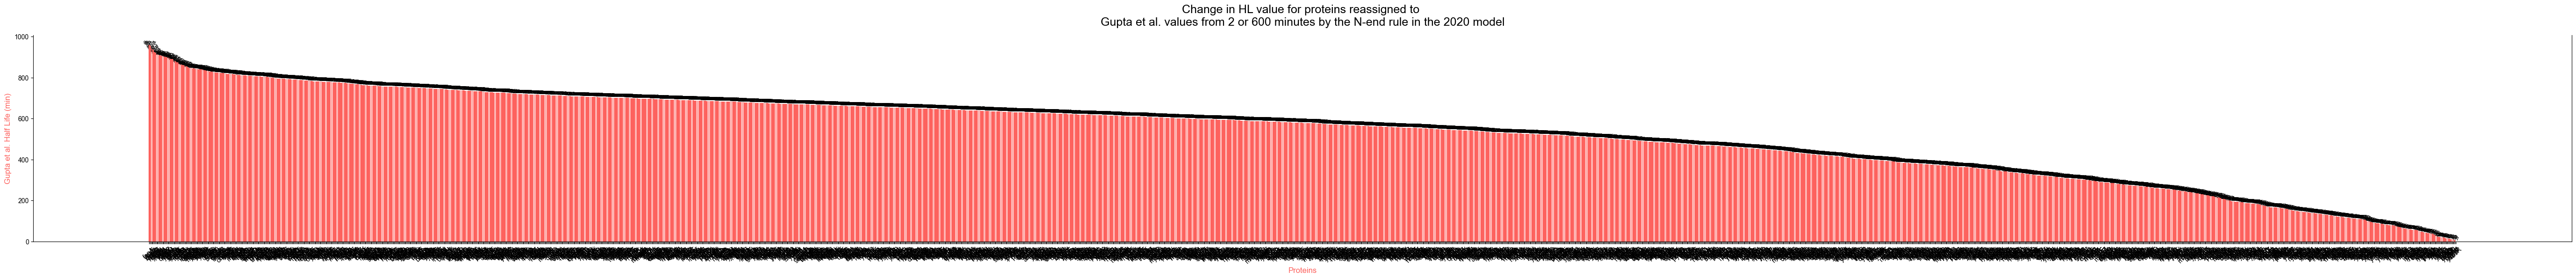

In [78]:
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional

# prep data: 
data = CLClim3NE1_HLs_Clim3[['common_name','new_half_life','HL_difference']]
data = data.sort_values(by="new_half_life", ascending=False)
data.set_index('common_name', inplace=True)

font_color = '#525252'
hfont = {'fontname':'Calibri'}
#facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data['new_half_life']
title0 = 'Change in HL value for proteins reassigned to \nGupta et al. values from 2 or 600 minutes by the N-end rule in the 2020 model'

fig, axes = plt.subplots(figsize=(55,5),  nrows=1)
fig.tight_layout()

axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )
for i, val in enumerate(column0):
    axes.text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )


    
axes.set(xticks=data.index, xticklabels=data.index)
for tick in axes.get_xticklabels():
    tick.set_rotation(45)

axes.set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )
axes.set_xlabel('Proteins', fontsize=12, color=color_red, )
axes.spines['top'].set_visible(False)


# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_graphs/all_HL_values_only.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

## Plot 2: all of the half lives, with bounds at greater than 800 and less than 200

In [79]:
# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_800 = CLClim3NE1_HLs_Clim3[CLClim3NE1_HLs_Clim3['new_half_life'] > 800] # 144
CLClim3NE1_HLs_Clim3_above_800 = CLClim3NE1_HLs_Clim3_above_800.copy()
CLClim3NE1_HLs_Clim3_above_800["sort_color"] = "red"
print(CLClim3NE1_HLs_Clim3_above_800.shape[0])

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_800_to_600 = CLClim3NE1_HLs_Clim3[(CLClim3NE1_HLs_Clim3['new_half_life'] <= 800) & (CLClim3NE1_HLs_Clim3['new_half_life'] > 600)] # 1060
CLClim3NE1_HLs_Clim3_800_to_600 = CLClim3NE1_HLs_Clim3_800_to_600.copy()
CLClim3NE1_HLs_Clim3_800_to_600["sort_color"] = "orange"
print(CLClim3NE1_HLs_Clim3_800_to_600.shape[0])

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_600_to_200 = CLClim3NE1_HLs_Clim3[(CLClim3NE1_HLs_Clim3['new_half_life'] <= 600) & (CLClim3NE1_HLs_Clim3['new_half_life'] > 200)] # 1208
CLClim3NE1_HLs_Clim3_600_to_200 = CLClim3NE1_HLs_Clim3_600_to_200.copy()
CLClim3NE1_HLs_Clim3_600_to_200["sort_color"] = "lightblue"
print(CLClim3NE1_HLs_Clim3_600_to_200.shape[0])

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_200_to_0 = CLClim3NE1_HLs_Clim3[(CLClim3NE1_HLs_Clim3['new_half_life'] <= 200) & (CLClim3NE1_HLs_Clim3['new_half_life'] > 0)] # 262
CLClim3NE1_HLs_Clim3_200_to_0 = CLClim3NE1_HLs_Clim3_200_to_0.copy()
CLClim3NE1_HLs_Clim3_200_to_0["sort_color"] = "blue"
print(CLClim3NE1_HLs_Clim3_200_to_0.shape[0])

# these all add up to 2674, so that checks with the 
# 1628 still have a half life of 600, and 7 should still have a covert lab half life. together, that is 4309 (I think this is the right number to add up to?) 

144
1060
1208
262


In [80]:
# todo: plot one where the middle three are just one large column that is the height of the sections next to it (like 801 to 600 and 200 to 0). OR have them be like tiny dots that line inbetween! that might look cool! 

In [81]:
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split = pd.concat([CLClim3NE1_HLs_Clim3_above_800, CLClim3NE1_HLs_Clim3_800_to_600, CLClim3NE1_HLs_Clim3_600_to_200, CLClim3NE1_HLs_Clim3_200_to_0], ignore_index=True)
# sort the data frame by the new half life:
CLClim3NE1_HLs_Clim3_split = CLClim3NE1_HLs_Clim3_split.sort_values(by="new_half_life", ascending=False)

# prepare data 
data = CLClim3NE1_HLs_Clim3_split[['common_name','new_half_life','sort_color']]
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': 1, 'orange': .2, 'lightblue': .2, 'blue': 1}


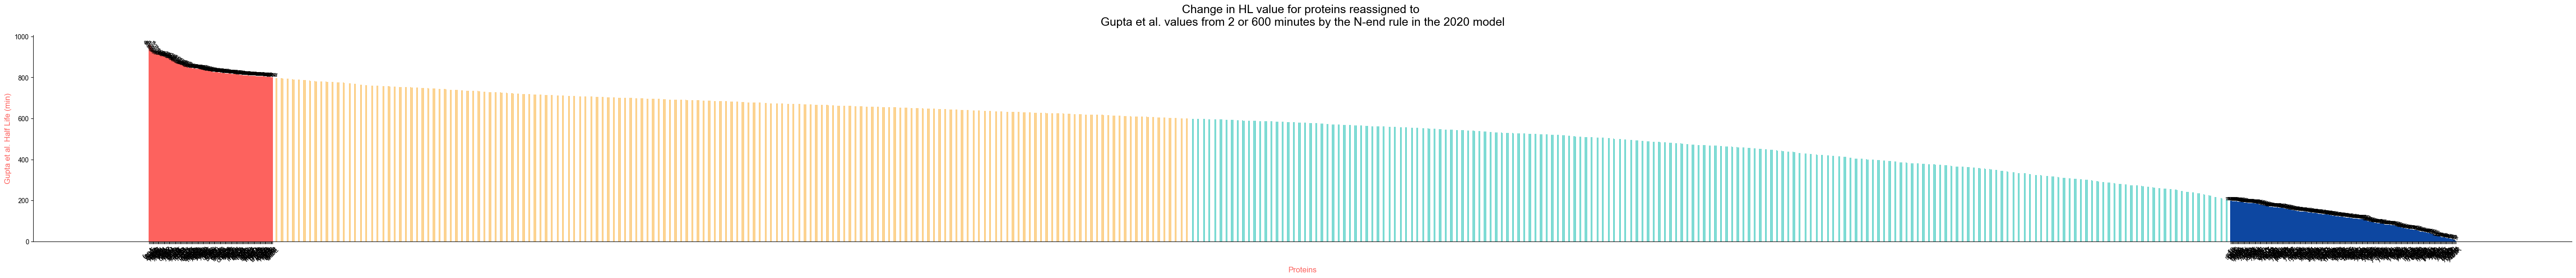

In [82]:
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional

font_color = '#525252'
hfont = {'fontname':'Calibri'}
#facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data['new_half_life']
title0 = 'Change in HL value for proteins reassigned to \nGupta et al. values from 2 or 600 minutes by the N-end rule in the 2020 model'

fig, axes = plt.subplots(figsize=(55,5),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )
ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(index[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        ticks_to_plot.append(index[i])
        axes.text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )
    if data['sort_color'].iloc[i] == 'blue':
        ticks_to_plot.append(index[i])
        axes.text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )


axes.set(xticks=ticks_to_plot, xticklabels=ticks_to_plot)
for tick in axes.get_xticklabels():
    tick.set_rotation(45)

axes.set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )
axes.set_xlabel('Proteins', fontsize=12, color=color_red, )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)


# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_graphs/all_HL_values_only_color_coded.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


## Plot 3: big time shrink down

In [119]:
# define bounds
upper = 900
lower = 50

# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_800 = CLClim3NE1_HLs_Clim3[CLClim3NE1_HLs_Clim3['new_half_life'] > upper] # 144
CLClim3NE1_HLs_Clim3_above_800 = CLClim3NE1_HLs_Clim3_above_800.copy()
CLClim3NE1_HLs_Clim3_above_800["sort_color"] = "red"
CLClim3NE1_HLs_Clim3_above_800["column_width"] = "1"
print(CLClim3NE1_HLs_Clim3_above_800.shape[0])

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_800_to_600 = CLClim3NE1_HLs_Clim3[(CLClim3NE1_HLs_Clim3['new_half_life'] <= upper) & (CLClim3NE1_HLs_Clim3['new_half_life'] > 600)] # 1060
CLClim3NE1_HLs_Clim3_800_to_600 = CLClim3NE1_HLs_Clim3_800_to_600.copy()
CLClim3NE1_HLs_Clim3_800_to_600["sort_color"] = "orange"
CLClim3NE1_HLs_Clim3_above_800["column_width"] = "4"
print(CLClim3NE1_HLs_Clim3_800_to_600.shape[0])

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_600_to_200 = CLClim3NE1_HLs_Clim3[(CLClim3NE1_HLs_Clim3['new_half_life'] <= 600) & (CLClim3NE1_HLs_Clim3['new_half_life'] > lower)] # 1208
CLClim3NE1_HLs_Clim3_600_to_200 = CLClim3NE1_HLs_Clim3_600_to_200.copy()
CLClim3NE1_HLs_Clim3_600_to_200["sort_color"] = "lightblue"
CLClim3NE1_HLs_Clim3_600_to_200["column_width"] = "4"
print(CLClim3NE1_HLs_Clim3_600_to_200.shape[0])

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_200_to_0 = CLClim3NE1_HLs_Clim3[(CLClim3NE1_HLs_Clim3['new_half_life'] <= lower) & (CLClim3NE1_HLs_Clim3['new_half_life'] > 0)] # 262
CLClim3NE1_HLs_Clim3_200_to_0 = CLClim3NE1_HLs_Clim3_200_to_0.copy()
CLClim3NE1_HLs_Clim3_200_to_0["sort_color"] = "blue"
CLClim3NE1_HLs_Clim3_200_to_0["column_width"] = "1"
print(CLClim3NE1_HLs_Clim3_200_to_0.shape[0])


# these all add up to 2674, so that checks with the 
# 1628 still have a half life of 600, and 7 should still have a covert lab half life. together, that is 4309 (I think this is the right number to add up to?) 

21
1183
1428
42


In [120]:
# make a new data frame that is more simple
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split = pd.concat([CLClim3NE1_HLs_Clim3_above_800, CLClim3NE1_HLs_Clim3_200_to_0], ignore_index=True)
data = CLClim3NE1_HLs_Clim3_split[['common_name','new_half_life','sort_color', 'column_width']]

# add a new rows to the data: 
new_rows = [
    {
        'common_name': f'$t_{{1/2}}$ between 600-{upper} mins,\nn={CLClim3NE1_HLs_Clim3_800_to_600.shape[0]}',
        'new_half_life': upper,
        'sort_color': 'orange',
        'column_width': 4
    },
    {
        'common_name': f'$t_{{1/2}}$ = 600 mins,\nn={2674}',
        'new_half_life': 600,
        'sort_color': 'green',
        'column_width': 4
    },
    {
        'common_name': f'$t_{{1/2}}$ between {lower}-600 mins,\nn={CLClim3NE1_HLs_Clim3_600_to_200.shape[0]}',
        'new_half_life': lower,
        'sort_color': 'lightblue',
        'column_width': 4
    }
]

# convert new rows to a DataFrame:
new_rows_df = pd.DataFrame(new_rows)
data = pd.concat([data, new_rows_df], ignore_index=True)

# sort the data
data = data.sort_values(by=['new_half_life'], ascending=False)
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': .2, 'orange': 2, 'green':3,'lightblue': 2, 'blue': .2}

upper_len = int(CLClim3NE1_HLs_Clim3_above_800.shape[0])
lower_len = int(CLClim3NE1_HLs_Clim3_200_to_0.shape[0])

first_ticks = np.ones(upper_len) * size_dict['red']
second_ticks = np.ones(1) * size_dict['orange']
third_ticks = np.ones(1) * size_dict['green']
fourth_ticks = np.ones(1) * size_dict['lightblue']
fifth_ticks = np.ones(lower_len) * size_dict['blue']
col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
col_widths = np.concatenate(col_widths)
col_widths

# from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
a = 0
x_positions = []
for i in range(len(col_widths)):
    if i == 0:
        a+=col_widths[i]
       
        x_positions.append(col_widths[i]/2)
        
    else:
        a += col_widths[i]
       
        x_positions.append(a - col_widths[i]/2)

x_positions = np.array(x_positions)
x_positions

array([ 0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9,  2.1,
        2.3,  2.5,  2.7,  2.9,  3.1,  3.3,  3.5,  3.7,  3.9,  4.1,  5.2,
        7.7, 10.2, 11.3, 11.5, 11.7, 11.9, 12.1, 12.3, 12.5, 12.7, 12.9,
       13.1, 13.3, 13.5, 13.7, 13.9, 14.1, 14.3, 14.5, 14.7, 14.9, 15.1,
       15.3, 15.5, 15.7, 15.9, 16.1, 16.3, 16.5, 16.7, 16.9, 17.1, 17.3,
       17.5, 17.7, 17.9, 18.1, 18.3, 18.5, 18.7, 18.9, 19.1, 19.3, 19.5])

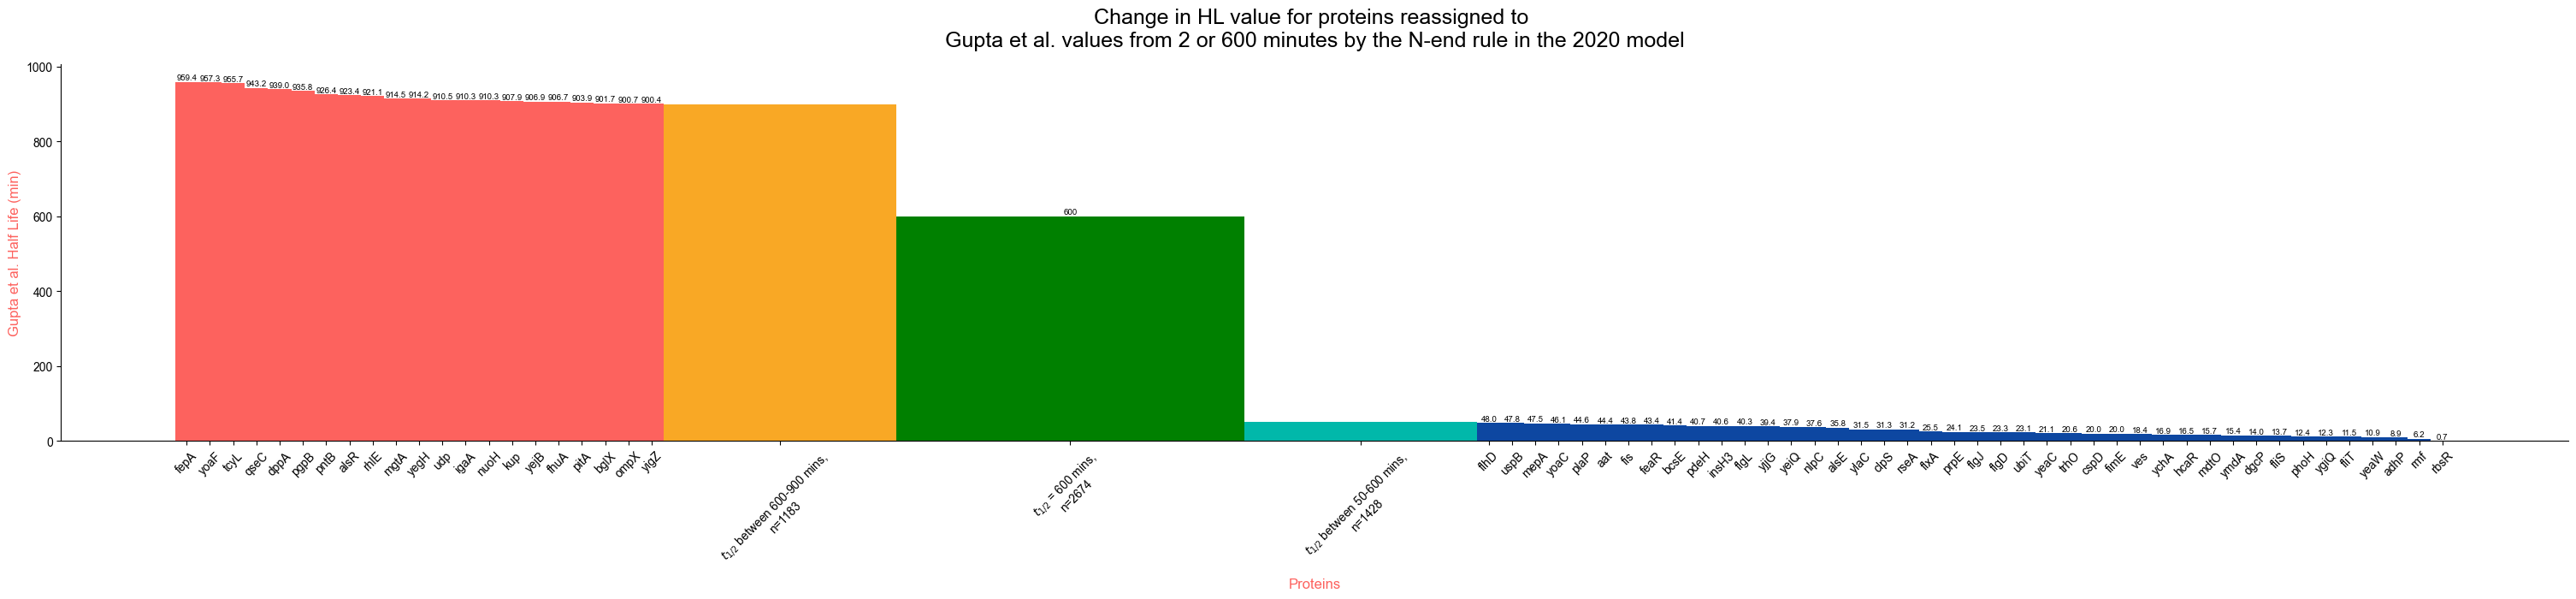

In [121]:
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional

font_color = '#525252'
hfont = {'fontname':'Calibri'}
#facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data['new_half_life']
title0 = 'Change in HL value for proteins reassigned to \nGupta et al. values from 2 or 600 minutes by the N-end rule in the 2020 model'

fig, axes = plt.subplots(figsize=(30,5),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )


ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        ticks_to_plot.append(index[i])
        axes.text(x_positions[i], val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )
    if data['sort_color'].iloc[i] == 'blue':
        ticks_to_plot.append(index[i])
        axes.text(x_positions[i], val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )
    if data['sort_color'].iloc[i] == 'green':
        ticks_to_plot.append(index[i])
        axes.text(x_positions[i], val + 0.5, f"{600}", ha='center', va='bottom', fontsize=7, rotation=0, )


axes.set(xticks=x_positions, xticklabels=data.index)
for tick in axes.get_xticklabels():
    tick.set_rotation(45)

axes.set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )
axes.set_xlabel('Proteins', fontsize=12, color=color_red, )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)


# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_graphs/all_HL_values_color_coded_with_600_included.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


# bar plot version with fold change

Prep the data first:

In [40]:
# find the differences between the orginal half life and the new half life:
CLClim3NE1_HLs_Clim3['HL_difference'] = CLClim3NE1_HLs_Clim3['new_half_life'] - CLClim3NE1_HLs_Clim3['original_half_life']
# make a new column that is the fold change in half life:
CLClim3NE1_HLs_Clim3['HL_fold_change'] = CLClim3NE1_HLs_Clim3['new_half_life'] / CLClim3NE1_HLs_Clim3['original_half_life']
# calcuate the ln 2 fold change:
CLClim3NE1_HLs_Clim3['HL_ln2_fold_change'] = np.log2(CLClim3NE1_HLs_Clim3['HL_fold_change'])



## just a general plot of all change:

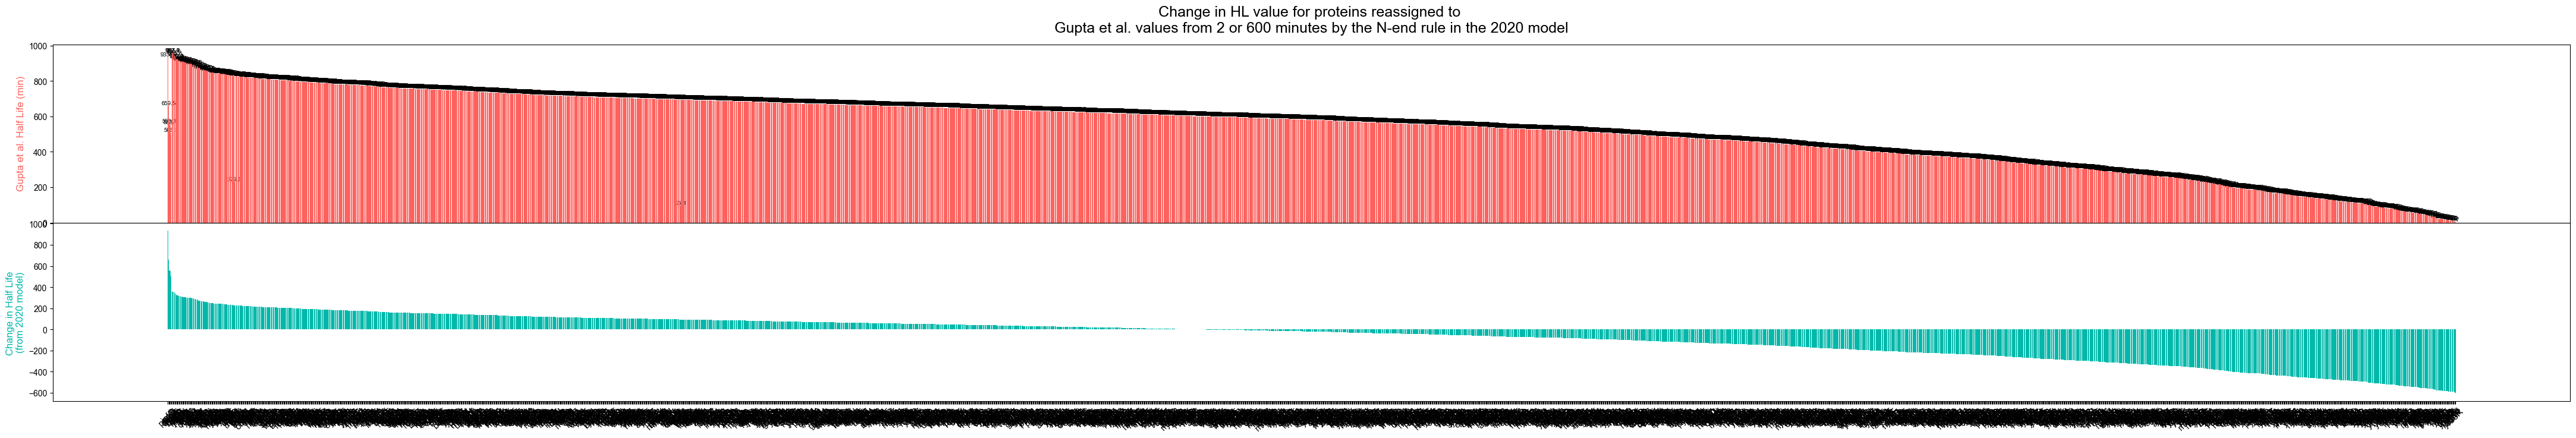

In [48]:
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional

# prep data: 
data = CLClim3NE1_HLs_Clim3[['common_name','new_half_life','HL_difference']]
data = data.sort_values(by="HL_difference", ascending=False)
data.set_index('common_name', inplace=True)

font_color = '#525252'
hfont = {'fontname':'Calibri'}
#facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data['new_half_life']
column1 = data['HL_difference']
title0 = 'Change in HL value for proteins reassigned to \nGupta et al. values from 2 or 600 minutes by the N-end rule in the 2020 model'
title1 = '2020 Half Life - Gupta et al. 2024 half life'

fig, axes = plt.subplots(figsize=(55,5),  nrows=2, sharex=True)
fig.tight_layout()

axes[0].bar(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, )
for i, val in enumerate(column0):
    axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )


axes[1].bar(index, column1, align='center', color=color_blue, zorder=10)
#axes[1].set_ylim(-600, -550) 
# todo: note that the axis can be set on this, as it is above^
#axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)


#axes[0].set(xticks=data.index, xticklabels=data.index)
#axes[0].xaxis.tick_bottom()
axes[1].tick_params(axis='x', labelsize=11) # tick color
    
axes[1].set(xticks=data.index, xticklabels=data.index)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)

axes[0].set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )
axes[1].set_ylabel('Change in Half Life \n(from 2020 model)', fontsize=12, color=color_blue, )

plt.subplots_adjust(hspace=0, top=1.2, bottom=0, left=0.18, right=0.95)

# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_graphs/all_HLs_with_differences_in_half_life.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

## Largest decrease in Half life: 

In [41]:
# find the proteins that had a difference of less than -400:
largest_HL_decrease = CLClim3NE1_HLs_Clim3[CLClim3NE1_HLs_Clim3['HL_difference'] < -550]
largest_HL_decrease = largest_HL_decrease.sort_values(by="HL_difference", ascending=True) # I think it is already sorted by difference 
largest_HL_decrease

,monomer_id,degradation_rate_constant,new_half_life,degradation_rate_source,common_name,protease_assignment,original_half_life,HL_difference,HL_fold_change,HL_ln2_fold_change
2337,PD03867,0.016298,0.708811,Gupta_et_al_MS_2024,rbsR,None,600,-599.291189,0.001181,-9.725345
1179,EG50004-MONOMER,0.001874,6.165352,Gupta_et_al_MS_2024,rmf,None,600,-593.834648,0.010276,-6.604635
44,ADHP-MONOMER,0.001303,8.867585,Gupta_et_al_MS_2024,adhP,None,600,-591.132415,0.014779,-6.080278
1590,G6988-MONOMER,0.001059,10.906607,Gupta_et_al_MS_2024,yeaW,None,600,-589.093393,0.018178,-5.781688
752,EG11389-MONOMER,0.001007,11.469439,Gupta_et_al_MS_2024,fliT,None,600,-588.530561,0.019116,-5.709096
1819,G7568-MONOMER,0.000937,12.335229,Gupta_et_al_MS_2024,ygiQ,None,600,-587.664771,0.020559,-5.604106
867,EG11734-MONOMER,0.000931,12.410689,Gupta_et_al_MS_2024,phoH,ClpP only,600,-587.589311,0.020684,-5.595307
751,EG11388-MONOMER,0.000846,13.660143,Gupta_et_al_MS_2024,fliS,None,600,-586.339857,0.022767,-5.456918
1587,G6980-MONOMER,0.000828,13.955536,Gupta_et_al_MS_2024,dgcP,None,600,-586.044464,0.023259,-5.426053
1408,G6549-MONOMER,0.000751,15.376756,Gupta_et_al_MS_2024,ymdA,None,600,-584.623244,0.025628,-5.286139


In [42]:
# plot the largest changes against the half lives and have the common name above the bars and the color dependent on the protease assignment:
data = largest_HL_decrease[['common_name','new_half_life','HL_difference']]
data.set_index('common_name', inplace=True)

data
    

,new_half_life,HL_difference
common_name,,
rbsR,0.708811,-599.291189
rmf,6.165352,-593.834648
adhP,8.867585,-591.132415
yeaW,10.906607,-589.093393
fliT,11.469439,-588.530561
ygiQ,12.335229,-587.664771
phoH,12.410689,-587.589311
fliS,13.660143,-586.339857
dgcP,13.955536,-586.044464


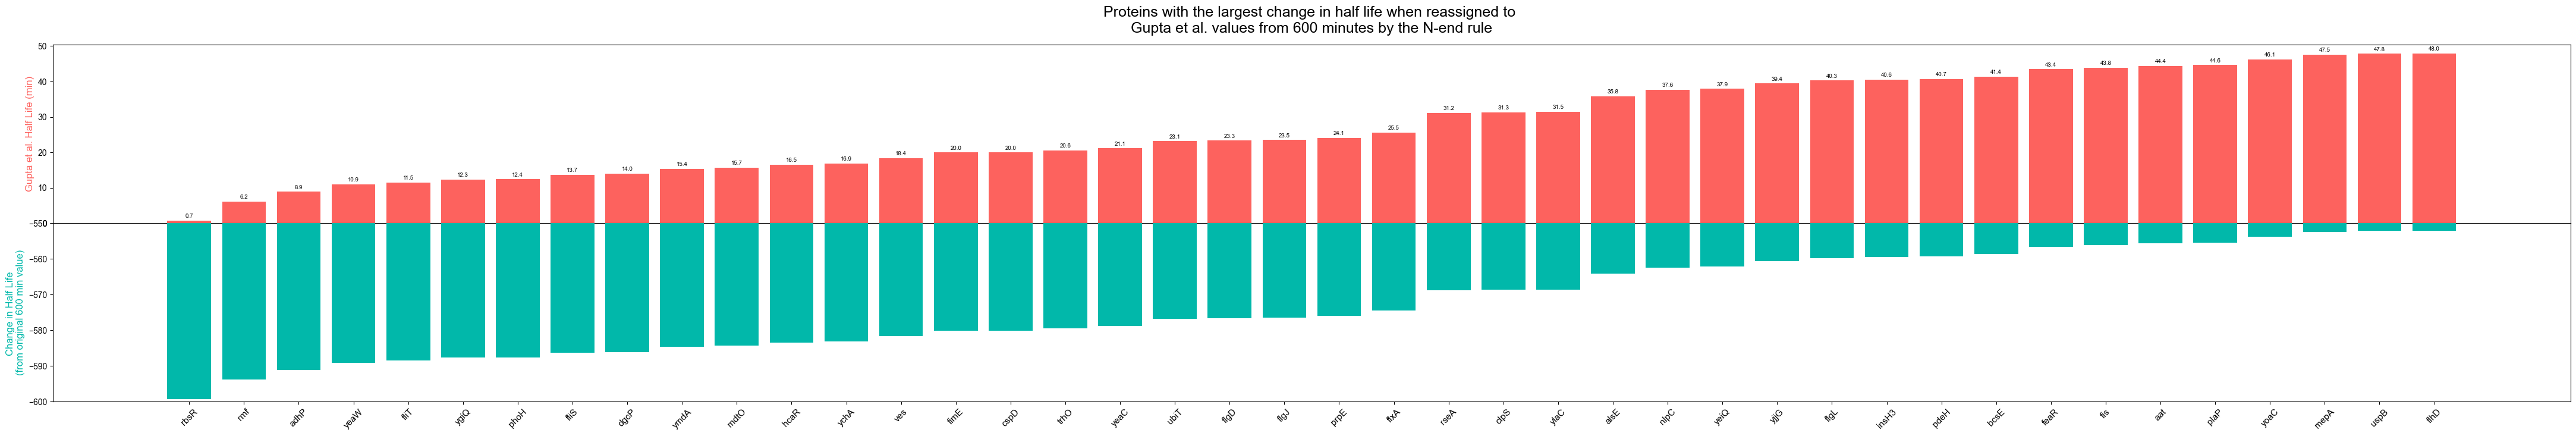

In [44]:
# using this thing: https://sharkcoder.com/data-visualization/mpl-bidirectional

font_color = '#525252'
hfont = {'fontname':'Calibri'}
#facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data['new_half_life']
column1 = data['HL_difference']
title0 = 'Proteins with the largest change in half life when reassigned to \nGupta et al. values from 600 minutes by the N-end rule'
title1 = 'N-end rule half life (600 mins) - Gupta et al. 2024 half life'

fig, axes = plt.subplots(figsize=(55,5),  nrows=2, sharex=True)
fig.tight_layout()

axes[0].bar(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, )
for i, val in enumerate(column0):
    axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )


axes[1].bar(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_ylim(-600, -550)
#axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)


#axes[0].set(xticks=data.index, xticklabels=data.index)
#axes[0].xaxis.tick_bottom()
axes[1].tick_params(axis='x', labelsize=11) # tick color
    
axes[1].set(xticks=data.index, xticklabels=data.index)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)

axes[0].set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )
axes[1].set_ylabel('Change in Half Life \n(from original 600 min value)', fontsize=12, color=color_blue, )

plt.subplots_adjust(hspace=0, top=1.2, bottom=0, left=0.18, right=0.95)

# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_graphs/Gupta_et_al_2024_largest_decreases_in_half_life.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

Idea: 
- have all of the half lives shown, but just have the ones with minimal change smaller in size and more opaque. 
- have the biggest increase and decrease more bold at the ends.
- have the names of the ones at the ends on the opposite side of the bar from where the values protrude out from
- have the half life on the top of the bar


ALSO
# todo: simply get rid of the ones with smaller fold changes in the middle so that the axis bar can be -550 to -600 on the one side 

In [ ]:
# using this thing: https://sharkcoder.com/data-visualization/mpl-bidirectional

# by just simply looking at the data in this table, I can see the following are in complexes: /Users/miagrahn/wcEcoli/out/complex_classification_tables/monomers_under_300_mins_sorted.csv
in_complexes = ['adhP', 'yeaW', 'mdtO', 'cspD', 'flgL', 'fis', 'mepA', 'flhD']

# phoH is the only one that is actively degraded here, so idk if its worth trying to make that special 


font_color = '#525252'
hfont = {'fontname':'Calibri'}
#facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data['half_life_(min)']
column1 = data['difference']
title0 = 'Proteins with the largest change in half life when reassigned to \nGupta et al. values from 600 minutes by the N-end rule'
title1 = 'N-end rule half life (600 mins) - Gupta et al. 2024 half life'

fig, axes = plt.subplots(figsize=(15,5),  nrows=2, sharex=True)
fig.tight_layout()

axes[0].bar(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, )
for i, val in enumerate(column0):
    if data.index[i] in in_complexes:
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, fontweight='bold', color='black')
    else:
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )


axes[1].bar(index, column1, align='center', color=color_blue, zorder=10)
#axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)


#axes[0].set(xticks=data.index, xticklabels=data.index)
#axes[0].xaxis.tick_bottom()
axes[1].tick_params(axis='x', labelsize=11) # tick color
    
axes[1].set(xticks=data.index, xticklabels=data.index)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)
    if tick.get_text() in in_complexes:
        tick.set_fontweight('bold')
        tick.set_color('black')
    else:
        tick.set_fontweight('normal')
        tick.set_color(font_color)

axes[0].set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )
axes[1].set_ylabel('Change in Half Life \n(from original 600 min value)', fontsize=12, color=color_blue, )

plt.subplots_adjust(hspace=0, top=1.2, bottom=0, left=0.18, right=0.95)

# save the figure:
out_pth = "out/figures/half_life_comparisons_PDR_UPDATE_MERGE/Clim3_related/Gupta_et_al_2024_largest_changes_in_half_life_complexes_highlighted.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

In [ ]:
# using this thing: https://sharkcoder.com/data-visualization/mpl-bidirectional

# by just simply looking at the data in this table, I can see the following are in complexes: /Users/miagrahn/wcEcoli/out/complex_classification_tables/monomers_under_300_mins_sorted.csv
in_complexes = ['adhP', 'yeaW', 'mdtO', 'cspD', 'flgL', 'fis', 'mepA', 'flhD']

# phoH is the only one that is actively degraded here, so idk if its worth trying to make that special 


font_color = '#525252'
hfont = {'fontname':'Calibri'}
#facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data['half_life_(min)']
column1 = data['difference']
title0 = 'Proteins with the largest change in half life when reassigned to \nGupta et al. values from 600 minutes by the N-end rule'
title1 = 'N-end rule half life (600 mins) - Gupta et al. 2024 half life'

fig, axes = plt.subplots(figsize=(15,5),  nrows=2, sharex=True)
fig.tight_layout()

axes[0].bar(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, )
for i, val in enumerate(column0):
    if data.index[i] in in_complexes:
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, fontweight='bold', color='black')
    else:
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )


axes[1].bar(index, column1, align='center', color=color_blue, zorder=10)
#axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)


#axes[0].set(xticks=data.index, xticklabels=data.index)
#axes[0].xaxis.tick_bottom()
axes[1].tick_params(axis='x', labelsize=11) # tick color
    
axes[1].set(xticks=data.index, xticklabels=data.index)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)
    if tick.get_text() in in_complexes:
        tick.set_fontweight('bold')
        tick.set_color('black')
    else:
        tick.set_fontweight('normal')
        tick.set_color(font_color)

axes[0].set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )
axes[1].set_ylabel('Change in Half Life \n(from original 600 min value)', fontsize=12, color=color_blue, )

plt.subplots_adjust(hspace=0, top=1.2, bottom=0, left=0.18, right=0.95)

# save the figure:
out_pth = "out/figures/half_life_comparisons_PDR_UPDATE_MERGE/Clim3_related/Gupta_et_al_2024_largest_changes_in_half_life_change_in_protein_counts_highlighted.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')